# Gradient Descent for Logistic Regression

## Goals

- update gradient descent for logistic regression.
- explore gradient descent on a familiar data set

In [1]:
import copy, math
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from lab_utils_common import  dlc, plot_data, plt_tumor_data, sigmoid, compute_cost_logistic
from plt_quad_logistic import plt_quad_logistic, plt_prob
plt.style.use('./plot_style.mplstyle')

## Data set 
Let's start with the same two feature data set used in the decision boundary notebook:

In [2]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

X_train, y_train.reshape(-1, 1)

(array([[0.5, 1.5],
        [1. , 1. ],
        [1.5, 0.5],
        [3. , 0.5],
        [2. , 2. ],
        [1. , 2.5]]),
 array([[0],
        [0],
        [0],
        [1],
        [1],
        [1]]))

As before, we'll use a helper function to plot this data. The data points with label $y=1$ are shown as red crosses, while the data points with label $y=0$ are shown as blue circles.

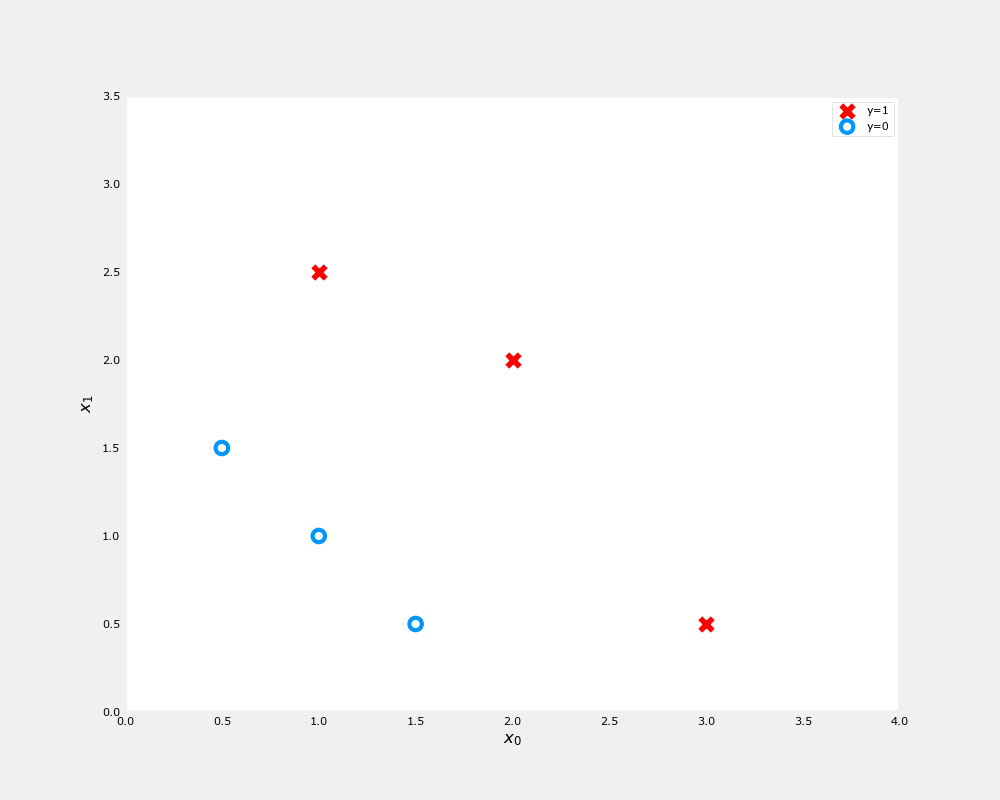

In [3]:
fig,ax = plt.subplots(1,1,figsize=(10, 8))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

## Logistic Gradient Descent

<img align="center" src="./images/C1_W3_Logistic_gradient_descent.png"     style=" width:700px; padding: 10px; " >

Recall the gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j-1$ features and the intercept, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    
Here *simultaniously* means that we calculate the partial derivatives for all the parameters before updating any of the parameters.

### Gradient Descent Implementation
The gradient descent algorithm implementation has two components: 
- The loop implementing equation (1) above. This is the `gradient_descent` function below.
- The calculation of the current gradient, equations (2) above. This is the `compute_gradient_logistic` function below.

#### Calculating the Gradient, Code Description
Implements equation (2) above for all $w_j$ and $b$.
There are many ways to implement this. Outlined below is this:
- initialize variables to accumulate `dj_dw` and `dj_db`
- for each example ($i=1, ..., m$)       
    - (Evaluated in the top-level loop) calculate the error for that example $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$ $\hspace{5cm}$
    - (Evaluated in the second-level loop) for each input value $x_{j}^{(i)}$ ($j=1, ...., n$) in this $i^{th}$ example,  
        - multiply the error by the input  $x_{j}^{(i)}$, and add this product to the corresponding element of `dj_dw`. (equation 2 above)
    - (Evaluated in the top-level loop) add the error to `dj_db` (equation 3 above) 

- divide `dj_db` and `dj_dw` by total number of examples (m)
- note that $\mathbf{x}^{(i)}$ in numpy is `X[i,:]` or `X[i]`  and $x_{j}^{(i)}$ is `X[i,j]`

In [4]:
# A row of training data
print('Row of training data =', X_train[3], '\nValue for a single predictor variable for the ith training example =', X_train[3, 1])


Row of training data = [3.  0.5] 
Value for a single predictor variable for the ith training example = 0.5


The function below is a nested for two with ($m\times n$) iterations.

In [5]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           # A (n,) row vector to contain the partial derivatives of the cost w.r.t. each parameter w_j
    dj_db = 0.                                       # A float scalar for updating the partial derivative of the cost w.r.t. the parameter b  

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          # A row in the matrix X[i] has shape (n,) and w has shape (n,), so (n,)(n,) = scalar prediction
        err_i  = f_wb_i  - y[i]                       # The deviation of the ith prediction from ith response (or target) is a scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      # The second level loop finishes to gives a vector of partial derivatives for the ith example
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   # A (n,) gradient vector for all predictor variables, each element is averaged over m examples
    dj_db = dj_db/m                                   # A scalar value for partial derivative w.r.t the intercept averaged over m examples
        
    return dj_db, dj_dw                               # A tuple returning the results for equation 2 above     

Check the implementation of the gradient function using the cell below.

In [6]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


**Expected output**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

#### Gradient Descent Code 
The code implementing equation (1) above is implemented below. 

In [7]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  # Make a deep copy of the objects contained in 'w_in' to 'w' to avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # Prevent resource exhaustion 
            J_history.append(compute_cost_logistic(X, y, w, b) )

        # Print cost at every intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ") # 4d formats an integer 'd' to a field of minimum width 4 with zero paddings on the left
        
    return w, b, J_history         # Return final w,b and J history for graphing


Let's run gradient descent on our data set.

In [8]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.684610468560574   
Iteration 1000: Cost 0.1590977666870457   
Iteration 2000: Cost 0.08460064176930078   
Iteration 3000: Cost 0.05705327279402531   
Iteration 4000: Cost 0.04290759421682   
Iteration 5000: Cost 0.03433847729884557   
Iteration 6000: Cost 0.02860379802212006   
Iteration 7000: Cost 0.02450156960879306   
Iteration 8000: Cost 0.02142370332569295   
Iteration 9000: Cost 0.019030137124109114   

updated parameters: w:[5.28 5.08], b:-14.222409982019837


#### Let's plot the results of gradient descent:

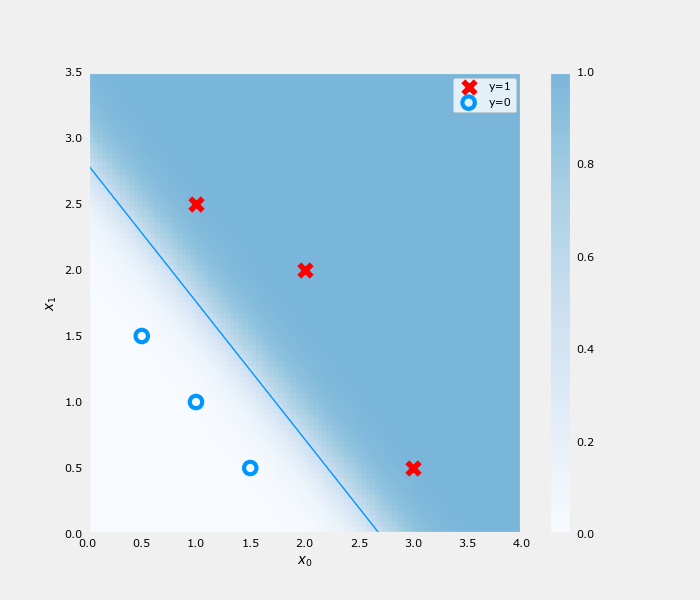

In [10]:
fig,ax = plt.subplots(1,1,figsize=(7, 6))
# plot the probability 
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c=dlc["dlblue"], lw=1)
plt.show()

In the plot above:
 - the shading reflects the probability y=1 (result prior to decision boundary)
 - the decision boundary is the line at which the probability = 0.5

The decision boundary is the following:

 - This model predicts $y=1$ if $-14.2224 + 5.28x_0 + 5.08x_1 >= 0$

This line is highted in blue in the chart above.
 

## Another Data set
Let's return to a one-variable data set. With just two parameters, $w$, $b$, it is possible to plot the cost function using a contour plot to get a better idea of what gradient descent is up to.

In [11]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

x_train, y_train

(array([0., 1., 2., 3., 4., 5.]), array([0, 0, 0, 1, 1, 1]))

As before, we'll use a helper function to plot this data. The data points with label $y=1$ are shown as red crosses, while the data points with label $y=0$ are shown as blue circles.

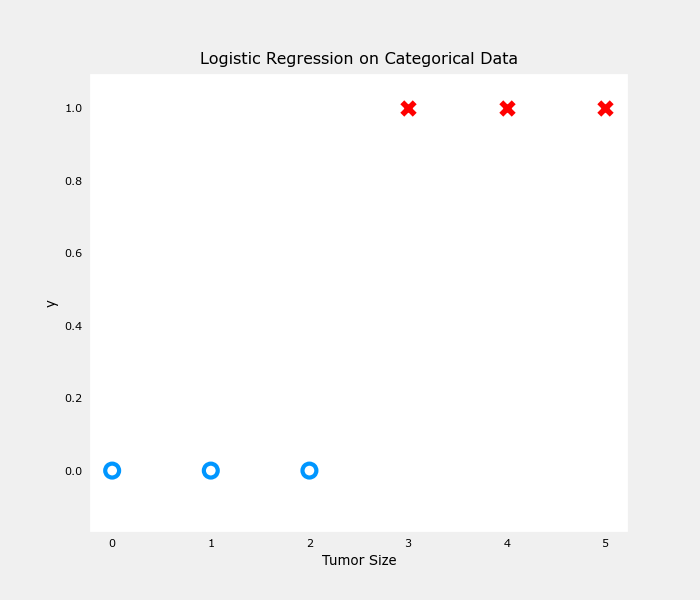

In [13]:
fig,ax = plt.subplots(1,1,figsize=(7, 6))
plt_tumor_data(x_train, y_train, ax)
plt.show()

In the plot below, try:
- changing $w$ and $b$ by clicking within the contour plot on the upper right.
    - changes may take a second or two
    - note the changing value of cost on the upper left plot.
    - note the cost is accumulated by a loss on each example (vertical dotted lines)
- run gradient descent by clicking the orange button.
    - note the steadily decreasing cost (contour and cost plot are in log(cost) 
    - clicking in the contour plot will reset the model for a new run
- to reset the plot, rerun the cell